# CHAPTER 6 머신러닝을 이용한 투자 전략

## 6.1 ETFs를 활용한 주가 방향 예측
### 6.1.1 데이터

In [1]:
import warnings
import glob
import os
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn import svm
import seaborn as sns; sns.set()

In [2]:
df = pd.read_csv('../ch06/ETFs_main.csv')
df.tail()

,Dates,CLOSE_SPY,OPEN,HIGH,LOW,VOLUME,CLOSE_GLD,CLOSE_FXY,CLOSE_T10Y2Y,CLOSE_TED,CLOSE_USO,CLOSE_UUP,CLOSE_VIX,CLOSE_VWO
2766,2018-12-20,247.17,249.86,251.620,245.0,252053406.0,119.24,85.87,1.7807,0.48,9.72,25.77,28.38,38.18
2767,2018-12-21,240.70,246.74,249.710,240.0,255345594.0,118.72,85.87,1.7651,0.48,9.57,25.94,30.11,37.87
2768,2018-12-24,234.34,239.04,240.836,234.0,147311594.0,120.02,86.55,1.7505,0.40,9.29,25.55,36.07,37.32
2769,2018-12-27,248.07,242.57,248.290,239.0,186267297.0,120.57,86.00,1.7581,0.44,9.62,25.57,29.96,37.90
2770,2018-12-28,247.75,249.58,251.400,246.0,153100188.0,121.06,86.63,1.7320,0.45,9.53,25.50,28.34,38.17


In [3]:
#기술적 지표 만들기
def moving_average(df, n):
    MA = pd.Series(df['CLOSE_SPY'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    df = df.join(MA)
    return df

def volume_moving_average(df, n):
    VMA = pd.Series(df['VOLUME'].rolling(n, min_periods=n).mean(), name='VMA_' + str(n))
    df = df.join(VMA)
    return df

def relative_strength_index(df, n):
    """Calculate Relative Strength Index(RSI) for given data.

    :param df: pandas.DataFrame
    :param n:
    :return: pandas.DataFrame
    """
    i = 0
    UpI = [0]
    DoI = [0]
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'HIGH'] - df.loc[i, 'HIGH']
        DoMove = df.loc[i, 'LOW'] - df.loc[i + 1, 'LOW']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
    RSI = pd.Series(PosDI / (PosDI + NegDI), name='RSI_' + str(n))
    df = df.join(RSI)
    return df

In [4]:
df = moving_average(df, 45)
df = volume_moving_average(df, 45)
df = relative_strength_index(df, 14)
df = df.set_index('Dates')
df = df.dropna()
df.tail()

,CLOSE_SPY,OPEN,HIGH,LOW,VOLUME,CLOSE_GLD,CLOSE_FXY,CLOSE_T10Y2Y,CLOSE_TED,CLOSE_USO,CLOSE_UUP,CLOSE_VIX,CLOSE_VWO,MA_45,VMA_45,RSI_14
Dates,,,,,,,,,,,,,,,,
2018-12-20,247.17,249.86,251.620,245.0,252053406.0,119.24,85.87,1.7807,0.48,9.72,25.77,28.38,38.18,269.767778,1.240592e+08,0.172439
2018-12-21,240.70,246.74,249.710,240.0,255345594.0,118.72,85.87,1.7651,0.48,9.57,25.94,30.11,37.87,269.018889,1.274610e+08,0.142578
2018-12-24,234.34,239.04,240.836,234.0,147311594.0,120.02,86.55,1.7505,0.40,9.29,25.55,36.07,37.32,267.995333,1.281067e+08,0.115003
2018-12-27,248.07,242.57,248.290,239.0,186267297.0,120.57,86.00,1.7581,0.44,9.62,25.57,29.96,37.90,267.275778,1.297876e+08,0.307099
2018-12-28,247.75,249.58,251.400,246.0,153100188.0,121.06,86.63,1.7320,0.45,9.53,25.50,28.34,38.17,266.639111,1.301996e+08,0.372653


In [5]:
df['target'] = df['CLOSE_SPY'].pct_change()
df['target'].describe()

count    2726.000000
mean        0.000270
std         0.013026
min        -0.098448
25%        -0.004320
50%         0.000545
75%         0.005791
max         0.128249
Name: target, dtype: float64

In [6]:
# df['target'] = np.where(df['target'] > 0.0005 , 1, -1)
df['target'] = np.where(df['target'] > 0 , 1, -1)
df['target'].value_counts()

target
 1    1471
-1    1256
Name: count, dtype: int64

In [7]:
df['target'] = df['target'].shift(-1)
df = df.dropna()
df['target'] = df['target'].astype(np.int64)

In [8]:
y_var = df['target']
# 예측에 사용하지 않는 변수 삭제
x_var = df.drop(['target', 'OPEN','HIGH','LOW', 'VOLUME','CLOSE_SPY'], axis=1)
x_var.head()

,CLOSE_GLD,CLOSE_FXY,CLOSE_T10Y2Y,CLOSE_TED,CLOSE_USO,CLOSE_UUP,CLOSE_VIX,CLOSE_VWO,MA_45,VMA_45,RSI_14
Dates,,,,,,,,,,,
2007-04-27,67.56,83.7300,2.4474,0.55,51.84,24.54,12.45,41.750,143.551556,1.106696e+08,0.670018
2007-04-30,67.09,83.7166,2.4361,0.57,51.24,24.49,14.22,40.935,143.601556,1.116466e+08,0.531751
2007-05-02,66.66,83.3800,2.4366,0.59,49.59,24.66,13.08,42.020,143.680667,1.121613e+08,0.554050
2007-05-03,67.49,83.1100,2.4346,0.60,49.28,24.69,13.09,42.435,143.780222,1.123421e+08,0.601028
2007-05-04,68.19,83.2300,2.4006,0.60,48.30,24.60,12.91,42.595,143.905111,1.128853e+08,0.665987


In [9]:
up=df[df['target']==1].target.count()
total=df.target.count()
print('up/down ratio: {0:.2f}'.format((up/total)))

up/down ratio: 0.54


### 6.1.2 모델 학습

In [10]:
#훈련 세트와 테스트 세트를 나눈다.
#shuffle=False을 설정해 기간이 섞이지 않도록 만든다.
X_train, X_test, y_train, y_test = train_test_split(x_var,
                                                    y_var,
                                                    test_size=0.3,
                                                    shuffle=False,
                                                    random_state=3)

#훈련 세트와 테스트 세트에 포함된 양성 샘플(up) 비율을 확인한다.
train_count = y_train.count()
test_count = y_test.count()

print('train set label ratio')
print(y_train.value_counts()/train_count)
print('test set label ratio')
print(y_test.value_counts()/test_count)

train set label ratio
target
 1    0.543501
-1    0.456499
Name: count, dtype: float64
test set label ratio
target
 1    0.530562
-1    0.469438
Name: count, dtype: float64


In [11]:
def get_confusion_matrix(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred)
    print('confusion matrix')
    print('accuracy:{0:.4f},precision:{1:.4f},recall:{2:.4f},F1:{3:.4f},ROC AUC score:{4:.4f}'.format(accuracy, precision, recall, f1,roc_score))

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

xgb_dis = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_dis.fit(X_train, y_train)
xgb_pred = xgb_dis.predict(X_test)

In [13]:
print(xgb_dis.score(X_train, y_train))

0.8763102725366876


### 6.1.3 머신러닝 모델을 활용한 결과 예측

In [14]:
get_confusion_matrix(y_test, xgb_pred)

confusion matrix
accuracy:0.4914,precision:0.5242,recall:0.4493,F1:0.4839,ROC AUC score:0.4942


### 6.1.4 확장 가능한 방법

## 6.2 k-최근접 이웃 알고리즘을 활용한 투자 전략
* k-최근접 이웃(KNN)
    * k-nearest neighbor
    * 유한한 특성을 가진 데이터 사이의 거리는 가깝다.
    * ![knn](images/knn.png)
### 6.2.1 데이터

In [15]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import FinanceDataReader as fdr

In [16]:
df = fdr.DataReader('SPY', start='2000')
df.dropna(inplace=True)
tmp_df = df[['Open', 'High', 'Low', 'Close']].copy()
print(tmp_df.head())

                 Open       High         Low     Close
Date                                                  
2000-01-03  148.25000  148.25000  143.875000  145.4375
2000-01-04  143.53125  144.06250  139.640625  139.7500
2000-01-05  139.93750  141.53125  137.250000  140.0000
2000-01-06  139.62500  141.50000  137.750000  137.7500
2000-01-07  140.31250  145.75000  140.062500  145.7500


In [17]:
tmp_df['Open-Close'] = tmp_df['Open'] - tmp_df['Close']
tmp_df['High-Low'] = tmp_df['High'] - tmp_df['Low']

tmp_df = tmp_df.dropna()
X = tmp_df[['Open-Close','High-Low']]
Y = np.where(tmp_df['Close'].shift(-1) > tmp_df['Open'].shift(-1), 1, -1)
print(X.head())

            Open-Close  High-Low
Date                            
2000-01-03     2.81250  4.375000
2000-01-04     3.78125  4.421875
2000-01-05    -0.06250  4.281250
2000-01-06     1.87500  3.750000
2000-01-07    -5.43750  5.687500


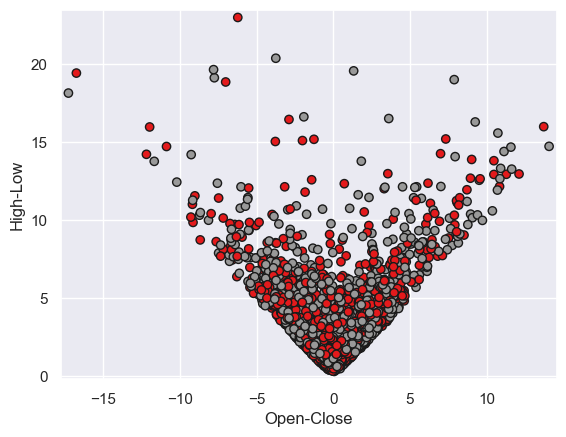

In [18]:
x_min, x_max = X['Open-Close'].min() - .5, X['Open-Close'].max() + .5
y_min, y_max = X['High-Low'].min() - .5, X['High-Low'].max() + .5

plt.scatter(X['Open-Close'], X['High-Low'], c=Y, cmap=plt.cm.Set1, edgecolor='k')
plt.xlabel('Open-Close')
plt.ylabel('High-Low')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

In [19]:
# 학습 데이터와 테스트 데이터를 분할한다
split_ratio = 0.7
split = int(split_ratio* len(tmp_df))
X_train = X[:split]
Y_train = Y[:split]

X_test = X[split:]
Y_test = Y[split:]

### 6.2.2 모델 학습

In [20]:
#for 반복문을 통해 1~15까지의 k값을 가진 모델을 만들어 본다
train_acc = []
test_acc = []

for n in range(1,15):
    clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=n)
    clf.fit(X_train, Y_train)
    prediction = clf.predict(X_test)
    train_acc.append(clf.score(X_train, Y_train))
    test_acc.append((prediction==Y_test).mean())

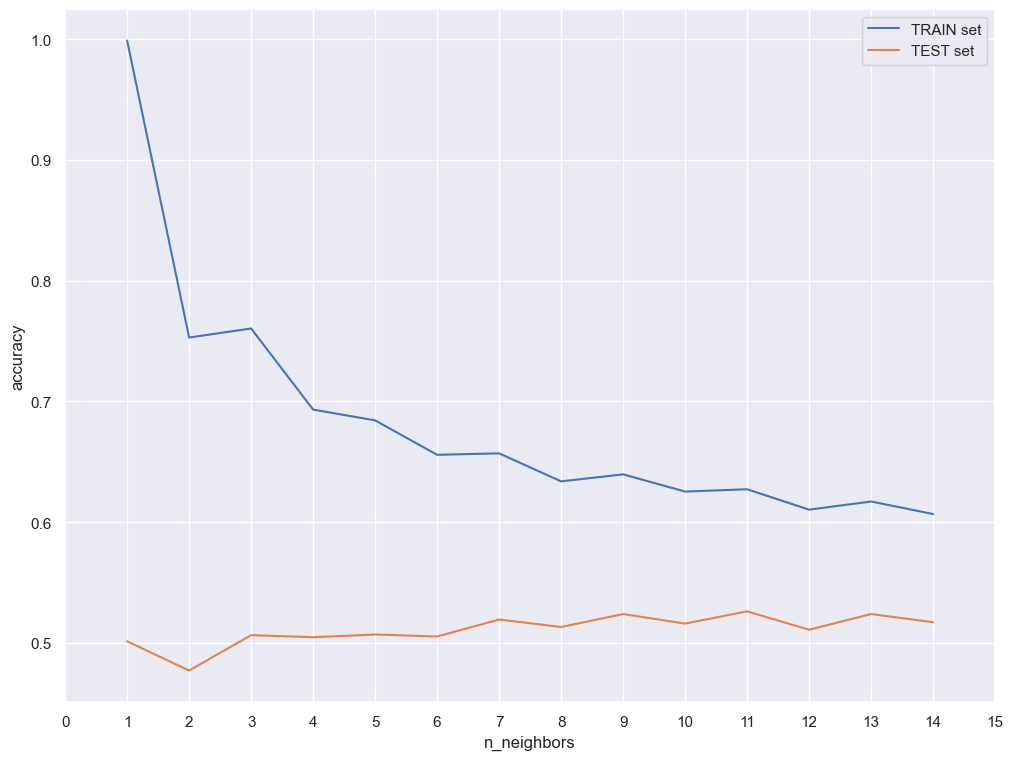

In [21]:
# 위에서 만든 결과를 그래프로 만들어 준다
plt.figure(figsize=(12, 9))
plt.plot(range(1, 15), train_acc, label='TRAIN set')
plt.plot(range(1, 15), test_acc, label='TEST set')
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.xticks(np.arange(0, 16, step=1))
plt.legend()

In [22]:
knn = KNeighborsClassifier(n_neighbors = 11)

knn.fit(X_train,Y_train)

accuracy_train = accuracy_score(Y_train, knn.predict(X_train))
accuracy_test = accuracy_score(Y_test, knn.predict(X_test))

print('훈련 정확도 : %.2f' % accuracy_train)
print('테스트 정확도 : %.2f' % accuracy_test)

훈련 정확도 : 0.63
테스트 정확도 : 0.53


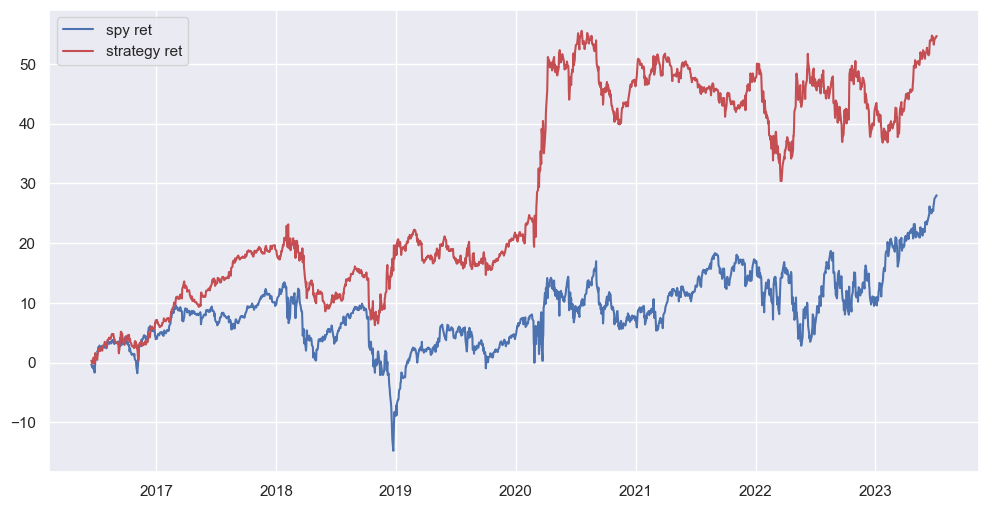

In [23]:
tmp_df['Predicted_Signal'] = knn.predict(X)

tmp_df['SPY_ret'] = np.log(tmp_df['Close'] / tmp_df['Open'])
cum_spy_ret = tmp_df[split:]['SPY_ret'].cumsum() * 100

tmp_df['strategy_ret'] = tmp_df['SPY_ret'] * tmp_df['Predicted_Signal'].shift(1)
cum_st_ret = tmp_df[split:]['strategy_ret'].cumsum() * 100

plt.figure(figsize=(12,6))
plt.plot(cum_spy_ret, color='b',label='spy ret')
plt.plot(cum_st_ret , color='r', label='strategy ret')
plt.legend()
plt.show()

## 6.3 클러스터링 알고리즘을 활용한 종목 분류
### 6.3.1 데이터

In [24]:
import pandas as pd
import FinanceDataReader as fdr
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [25]:
#Wikipeda에서 S&P500에 포함된 회사들의 리스트를 가져온다
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
data_table = pd.read_html(sp500_url)
tickers = data_table[0]['Symbol'].tolist()  #TICKER명만 리스트로 만든다.
security = data_table[0]['Security'].tolist() #Ticker명에 해당하는 회사 전체 이름을 리스트로 가져온다 (이해를 돕기 위한 작업이므로 건너뛰어도 무방하다)
sector = data_table[0]['GICS Sector'].tolist()

tickers = tickers[::7] #이해를 돕기위해 적은 양의 데이터만 사용하도록 하겠다.
security = security[::7]
sector = sector[::7]

prices_list = []
#리스트 길이가 같은지 확인한다. equal 함수를 사용해도 되지만, 데이터가 복잡하지 않기 때문에 가장 간단한 방법을 사용했다.
print(len(tickers))
print(len(security))
print(len(sector))

72
72
72


In [26]:
#데이터 불러오기. 2017년1월1일 부터 2020년 2월 28일까지의 데이터를 가져온다.
# for ticker in tickers:
#     try:
#         prices = fdr.DataReader(ticker,'yahoo','01/01/2017')['Adj Close']
#         prices = pd.DataFrame(prices)
#         prices.columns = [ticker]
#         prices_list.append(prices)
#     except:
#         pass
#     prices_df = pd.concat(prices_list,axis=1)
#
# prices_df.sort_index(inplace=True)
prices_df = fdr.DataReader(','.join(tickers), start='2017')
prices_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1638 entries, 2017-01-03 to 2023-07-07
Data columns (total 72 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MMM     1638 non-null   float64
 1   ADBE    1638 non-null   float64
 2   AKAM    1638 non-null   float64
 3   ALL     1638 non-null   float64
 4   AEE     1638 non-null   float64
 5   AMP     1638 non-null   float64
 6   AON     1638 non-null   float64
 7   AJG     1638 non-null   float64
 8   AVY     1638 non-null   float64
 9   BDX     1638 non-null   float64
 10  BLK     1638 non-null   float64
 11  BMY     1638 non-null   float64
 12  CDNS    1638 non-null   float64
 13  CCL     1638 non-null   float64
 14  CE      1638 non-null   float64
 15  CHTR    1638 non-null   float64
 16  CTAS    1638 non-null   float64
 17  KO      1638 non-null   float64
 18  ED      1638 non-null   float64
 19  CSGP    1638 non-null   float64
 20  DHI     1638 non-null   float64
 21  DVN     1638 non-nu

In [27]:
col_mask = prices_df.isnull().any(axis=0)
row_mask = prices_df.isnull().any(axis=1)
prices_df.loc[row_mask, col_mask].columns

Index(['IR'], dtype='object')

In [28]:
num = prices_df.columns.get_loc('IR')
del sector[num]
del security[num]
len(sector)
len(security)

71

In [29]:
prices_df.dropna(axis=1, inplace=True)
print(prices_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1638 entries, 2017-01-03 to 2023-07-07
Data columns (total 71 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MMM     1638 non-null   float64
 1   ADBE    1638 non-null   float64
 2   AKAM    1638 non-null   float64
 3   ALL     1638 non-null   float64
 4   AEE     1638 non-null   float64
 5   AMP     1638 non-null   float64
 6   AON     1638 non-null   float64
 7   AJG     1638 non-null   float64
 8   AVY     1638 non-null   float64
 9   BDX     1638 non-null   float64
 10  BLK     1638 non-null   float64
 11  BMY     1638 non-null   float64
 12  CDNS    1638 non-null   float64
 13  CCL     1638 non-null   float64
 14  CE      1638 non-null   float64
 15  CHTR    1638 non-null   float64
 16  CTAS    1638 non-null   float64
 17  KO      1638 non-null   float64
 18  ED      1638 non-null   float64
 19  CSGP    1638 non-null   float64
 20  DHI     1638 non-null   float64
 21  DVN     1638 non-nu

In [30]:
df = prices_df.pct_change().iloc[1:].T
print(len(df))

71


In [31]:
#회사명 리스트와 값의 리스트를 저장한다.
companies = list(df.index)
companies
movements = df.values
movements

array([[ 0.00151645, -0.00342082,  0.00292605, ..., -0.02481711,
        -0.02352225,  0.01017551],
       [ 0.00637801,  0.0169964 ,  0.02256632, ...,  0.00422501,
        -0.01225219,  0.0082694 ],
       [ 0.01124762,  0.01785454,  0.00345073, ..., -0.01204554,
        -0.0079805 ,  0.00301673],
       ...,
       [-0.00688989,  0.00177128,  0.03131216, ...,  0.00676062,
        -0.00588989, -0.00316992],
       [ 0.00889321,  0.01044734, -0.00323105, ..., -0.00894451,
        -0.01744892,  0.02418864],
       [ 0.01490427, -0.00912878, -0.00700977, ..., -0.01439686,
        -0.00616948,  0.00027386]])

In [32]:
len(security)

71

In [33]:
len(sector)

71

In [34]:
normalize = Normalizer()
array_norm = normalize.fit_transform(df)
df_norm = pd.DataFrame(array_norm, columns=df.columns)
final_df = df_norm.set_index(df.index)
final_df.head(10)

Date,2017-01-04,2017-01-05,2017-01-06,2017-01-09,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-17,2017-01-18,...,2023-06-23,2023-06-26,2023-06-27,2023-06-28,2023-06-29,2023-06-30,2023-07-03,2023-07-05,2023-07-06,2023-07-07
MMM,0.002314,-0.005220,0.004465,-0.008219,-0.005939,0.011320,-0.003860,-0.000430,-0.001118,0.010588,...,0.004406,-0.004696,-0.032672,0.004814,0.010371,0.013069,0.016007,-0.037867,-0.035891,0.015526
ADBE,0.007078,0.018861,0.025042,0.002767,-0.003169,0.007483,-0.004073,-0.000613,-0.005419,0.008117,...,0.016591,-0.011928,0.022587,-0.015514,0.003082,0.011974,-0.008578,0.004689,-0.013596,0.009177
AKAM,0.014519,0.023048,0.004454,0.003884,0.005163,-0.002939,-0.003498,0.001661,-0.004240,-0.003514,...,0.005411,-0.002622,0.013135,-0.004334,0.002029,0.009842,0.020827,-0.015549,-0.010302,0.003894
ALL,0.004073,-0.006905,0.002448,-0.021592,0.013639,0.003891,-0.005311,0.004305,-0.000818,0.013703,...,-0.006573,0.020086,-0.004436,0.003059,0.003191,-0.000692,0.020362,-0.006424,-0.017569,-0.006805
AEE,0.001917,0.008298,0.012703,-0.034986,-0.000644,0.007407,-0.007695,0.000322,0.018679,-0.006051,...,-0.029695,0.023812,0.012453,-0.035261,0.002898,0.014052,0.024182,0.017979,-0.009194,-0.020499
AMP,0.031428,-0.013299,0.017713,-0.004173,-0.004281,0.003018,0.000274,0.001641,-0.033863,0.017496,...,-0.011814,0.009599,0.020303,-0.002317,0.019994,0.001804,0.009224,-0.009645,-0.010619,0.012708
AON,0.017557,0.002400,0.012265,-0.013291,-0.010863,0.000568,0.000000,0.008804,0.004660,0.006055,...,-0.009406,-0.005020,0.015738,-0.000240,0.040909,0.014403,-0.030171,-0.001086,-0.006287,-0.008162
AJG,0.021007,0.003772,0.003763,-0.023154,0.000635,0.001903,0.003168,0.007273,-0.007557,0.011386,...,-0.002813,-0.014322,0.011999,-0.009875,0.029803,0.037953,-0.025672,-0.001769,0.002849,-0.017448
AVY,0.037727,-0.013022,0.017967,0.002924,0.003100,-0.000546,-0.010374,0.000367,0.005501,0.013149,...,-0.000473,0.010563,0.009462,-0.038279,0.020150,0.030007,0.012938,-0.036989,0.008160,0.015440
BDX,-0.002137,-0.001426,0.031510,0.009810,0.020600,0.027232,-0.002128,-0.001356,0.000679,0.005427,...,-0.009898,-0.000393,0.011532,0.005011,0.009732,0.022513,-0.013304,-0.010394,-0.009232,-0.012659


In [35]:
#누락된 데이터가 없는지 확인한다.
col_mask = df.isnull().any(axis=0)
row_mask = df.isnull().any(axis=1)
df.loc[row_mask, col_mask]

Date


In [36]:
final_df.shape

(71, 1637)

### 6.3.2 클러스터링

In [37]:
num_of_clusters = range(2,12)
error = []
for num_clusters in num_of_clusters:
    clusters = KMeans(num_clusters)
    clusters.fit(final_df)
    error.append(clusters.inertia_/100)
table=pd.DataFrame({"Cluster_Numbers":num_of_clusters, "Error_Term":error})

print(table)

c:\users\dukim\workspace\study\stock\algotrade\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\users\dukim\workspace\study\stock\algotrade\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\users\dukim\workspace\study\stock\algotrade\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\users\dukim\workspace\study\stock\algotrade\venv\lib\site-packages\sklearn\cluster\_kmeans.

   Cluster_Numbers  Error_Term
0                2    0.391617
1                3    0.373962
2                4    0.362557
3                5    0.347069
4                6    0.339487
5                7    0.326726
6                8    0.313893
7                9    0.305422
8               10    0.299066
9               11    0.287796


c:\users\dukim\workspace\study\stock\algotrade\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\users\dukim\workspace\study\stock\algotrade\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


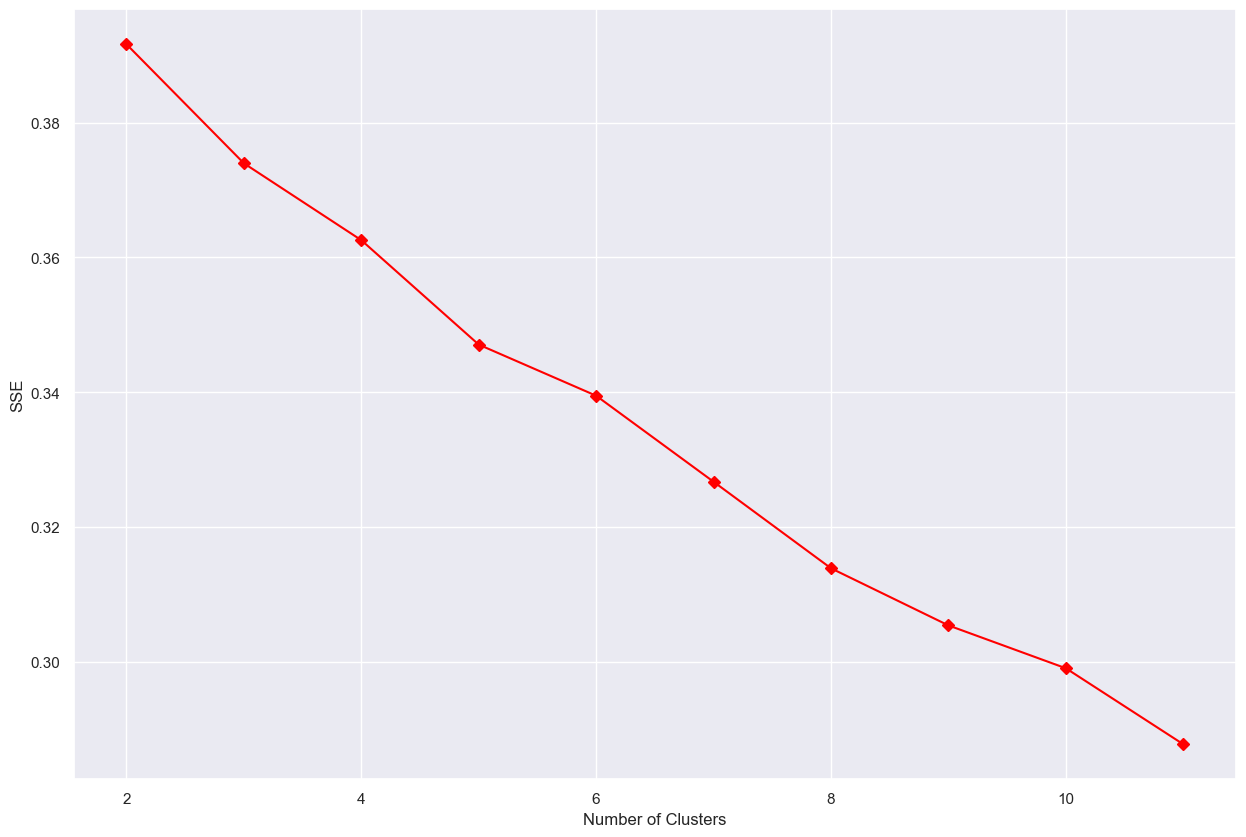

In [38]:
from sklearn import metrics
plt.figure(figsize=(15,10))
plt.plot(table.Cluster_Numbers, table.Error_Term, marker = "D", color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

In [39]:
clusters = KMeans(7)
clusters.fit(final_df)
clusters.labels_

c:\users\dukim\workspace\study\stock\algotrade\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([1, 3, 3, 1, 6, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 3, 1, 6, 6, 3, 1, 2,
       1, 1, 3, 2, 1, 1, 2, 0, 1, 1, 0, 1, 1, 1, 3, 0, 5, 6, 0, 1, 2, 1,
       2, 1, 2, 4, 1, 1, 2, 2, 6, 3, 1, 3, 3, 1, 2, 3, 1, 2, 1, 3, 2, 2,
       3, 0, 1, 1, 1])

In [40]:
labels = clusters.predict(movements)
labels

array([1, 3, 3, 1, 6, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 3, 1, 6, 6, 3, 1, 2,
       1, 1, 3, 2, 1, 1, 2, 0, 1, 1, 0, 1, 1, 1, 3, 0, 5, 6, 0, 1, 2, 1,
       2, 1, 2, 4, 1, 1, 2, 2, 6, 3, 1, 3, 3, 1, 2, 3, 1, 2, 1, 3, 2, 2,
       3, 0, 1, 1, 1])

In [41]:
clustered_result = pd.DataFrame({'labels': labels, 'tickers': companies, 'full-name':security, 'sector':sector})
clustered_result.sort_values('labels')

,labels,tickers,full-name,sector
29,0,FLT,Fleetcor,Financials
67,0,V,Visa Inc.,Financials
32,0,GPN,Global Payments,Financials
37,0,JKHY,Jack Henry & Associates,Financials
40,0,LDOS,Leidos,Industrials
...,...,...,...,...
52,6,PFE,Pfizer,Health Care
4,6,AEE,Ameren,Utilities
39,6,KHC,Kraft Heinz,Consumer Staples
17,6,KO,Coca-Cola Company (The),Consumer Staples


In [42]:
final_df['Cluster'] = clusters.labels_
final_df.head()

Date,2017-01-04 00:00:00,2017-01-05 00:00:00,2017-01-06 00:00:00,2017-01-09 00:00:00,2017-01-10 00:00:00,2017-01-11 00:00:00,2017-01-12 00:00:00,2017-01-13 00:00:00,2017-01-17 00:00:00,2017-01-18 00:00:00,...,2023-06-26 00:00:00,2023-06-27 00:00:00,2023-06-28 00:00:00,2023-06-29 00:00:00,2023-06-30 00:00:00,2023-07-03 00:00:00,2023-07-05 00:00:00,2023-07-06 00:00:00,2023-07-07 00:00:00,Cluster
MMM,0.002314,-0.005220,0.004465,-0.008219,-0.005939,0.011320,-0.003860,-0.000430,-0.001118,0.010588,...,-0.004696,-0.032672,0.004814,0.010371,0.013069,0.016007,-0.037867,-0.035891,0.015526,1
ADBE,0.007078,0.018861,0.025042,0.002767,-0.003169,0.007483,-0.004073,-0.000613,-0.005419,0.008117,...,-0.011928,0.022587,-0.015514,0.003082,0.011974,-0.008578,0.004689,-0.013596,0.009177,3
AKAM,0.014519,0.023048,0.004454,0.003884,0.005163,-0.002939,-0.003498,0.001661,-0.004240,-0.003514,...,-0.002622,0.013135,-0.004334,0.002029,0.009842,0.020827,-0.015549,-0.010302,0.003894,3
ALL,0.004073,-0.006905,0.002448,-0.021592,0.013639,0.003891,-0.005311,0.004305,-0.000818,0.013703,...,0.020086,-0.004436,0.003059,0.003191,-0.000692,0.020362,-0.006424,-0.017569,-0.006805,1
AEE,0.001917,0.008298,0.012703,-0.034986,-0.000644,0.007407,-0.007695,0.000322,0.018679,-0.006051,...,0.023812,0.012453,-0.035261,0.002898,0.014052,0.024182,0.017979,-0.009194,-0.020499,6


In [43]:
final_df.tail()

Date,2017-01-04 00:00:00,2017-01-05 00:00:00,2017-01-06 00:00:00,2017-01-09 00:00:00,2017-01-10 00:00:00,2017-01-11 00:00:00,2017-01-12 00:00:00,2017-01-13 00:00:00,2017-01-17 00:00:00,2017-01-18 00:00:00,...,2023-06-26 00:00:00,2023-06-27 00:00:00,2023-06-28 00:00:00,2023-06-29 00:00:00,2023-06-30 00:00:00,2023-07-03 00:00:00,2023-07-05 00:00:00,2023-07-06 00:00:00,2023-07-07 00:00:00,Cluster
VRSN,0.030471,0.015188,0.018785,0.017129,-0.044844,0.029725,0.001765,-0.003525,-0.008658,0.005511,...,-0.012127,0.012946,0.008833,0.000769,0.019469,-0.019333,-0.002946,0.004364,-0.004351,3
V,0.011998,0.017210,0.020268,-0.008211,-0.007898,0.008843,-0.007714,-0.003607,0.001627,0.005959,...,-0.020776,0.006744,0.004002,0.040940,0.019789,0.003028,0.009126,-0.003493,-0.014927,0
WAT,-0.009432,0.002425,0.042866,-0.007824,-0.015934,0.015625,-0.007675,0.029388,0.002034,0.015186,...,-0.000527,-0.010541,-0.001593,0.023983,0.023988,-0.009091,0.009255,-0.008063,-0.004340,1
WY,0.009810,0.011524,-0.003564,0.004291,-0.008548,0.008256,-0.013895,0.002526,-0.001440,-0.003605,...,0.018499,0.032821,0.047116,0.004319,0.005957,0.000988,-0.009866,-0.019247,0.026682,1
XYL,0.019887,-0.012181,-0.009353,-0.005652,-0.006216,0.007060,-0.029711,0.012708,-0.015324,0.006367,...,-0.004326,0.011333,-0.012792,0.009657,0.015340,-0.009360,-0.019210,-0.008232,0.000365,1


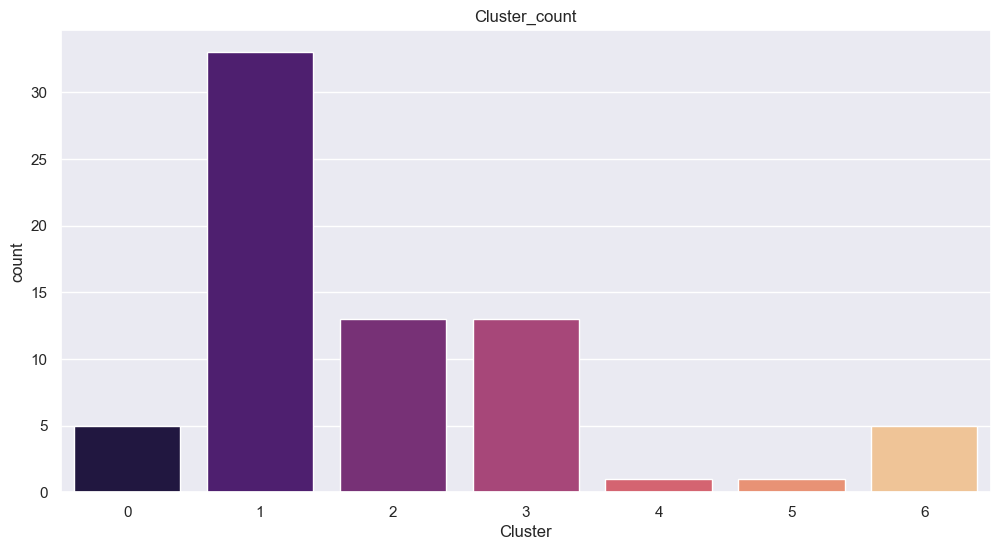

<Figure size 640x480 with 0 Axes>

In [44]:
plt.figure(figsize=(12,6))
sns.countplot(x = 'Cluster', data = final_df, palette = 'magma')
plt.title('Cluster_count')
plt.show()
plt.savefig('cluster_count.png', dpi=300)

## 6.4 마치며
* 트리 모델 기반 전략 검토
* k-최근접 이웃 알고리즘 전략 검토
* 클러스터링을 활용한 종목 분류 방법 검토